# Machine Learning Workshop

The following presents a detailed step-by-step walkthrough of a Machine Learning application with realistic data, the following is intended to provide an overview with full code examples.

In this walktrhough we'll be creating a model to perform classification in order to determine the survival outcome of a passenger onboard the Titanic. This dataset is based on what is provided by Kaggle.

Let's get started!

## Import Libraries

First we need to import all of the needed libraries, we will be using the plotting libraries matplotlib and seaborn in order to better understand the data and assist us in feature engineering.

In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
palette = sns.color_palette('deep', 5)
palette[1], palette[2] = palette[2], palette[1]
%matplotlib inline

The following libraries are used to provide the Machine Learning operations using scikit-learn.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score

## Load the Data

Next let's load the titanic dataset using Pandas, an extremely useful tool for dealing with large amounts of data based off of R's dataframes.

In [3]:
titanic = pd.read_csv('titanic.csv')

Next, let's view a sample of the data to see what we're working with.

In [4]:
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


As you can see there are a lot of different attributes describing the passengers onboard the Titanic, the column that we are trying to predict with our model is "Survived". We want to know if there any intrinsic features in this data that might be indicative of whether or not a passenger survived and that can be provided to our model.

The following is summary of each column.

- Survived is the outcome, 0 or 1 (1 is death)
- Pclass is the class the passenger was in, 1st class, 2nd, 3rd
- Name of passenger, sex of passenger
- Age (should convert to int)
- SibSp the number of siblings / spouses abord the ship
- Parch the number of parents / children aboard
- Ticket
- Fare is how much they paid for the ticket
- Cabin if it is known, there are a number of NaN
- Embarked is the port where they embarked on the ship

# Data Analysis (Exploratory Data Analysis)

Now that we have the data and understand what we're working with, the next step is to analyze the data and look for errors. All of these errors will need to be corrected in the data before we can proceed.


## Finding Missing Data

Before we do any analysis on the data we must first have a better understanding of how much missing data we're dealing with. The following plot produces a heatmap of missing data, where each yellow line indicates a column at a row where there is missing data.

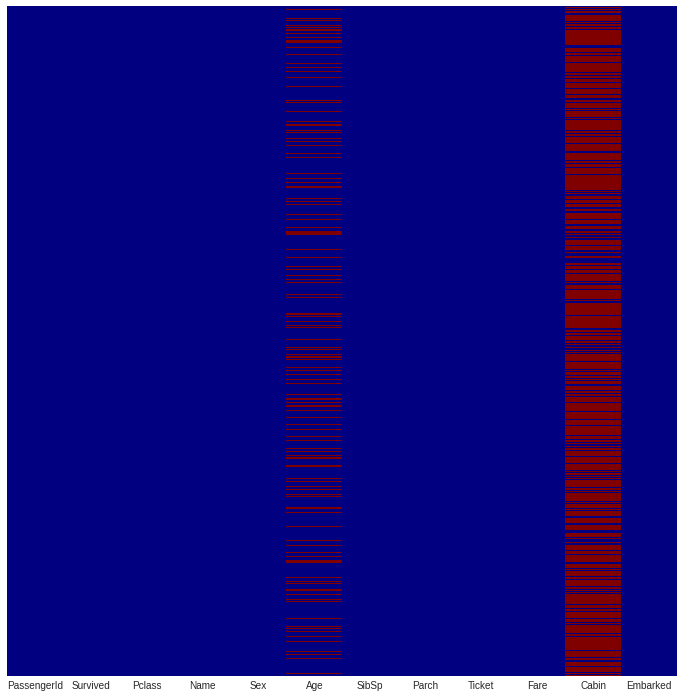

In [8]:
plt.figure(figsize=(12, 12))
sns.heatmap(titanic.isnull(), yticklabels=False, cbar=False, cmap='jet')

From this diagram we can see that there is some data missing for the Age column, most of the data is missing for the cabin, and there appears to be a small amount of missing data for Embarked.

**We will clean this data later before moving onto feature engineering.**

## Exploratory Data Analysis

Now let's look at some of the attributes of the data and try to get a better understanding, often it's important to know whether or not the target (label) is balanced.

Here we can see that there are more that survived than died in the Titanic, that's always good news!

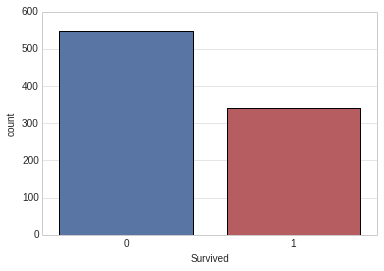

In [9]:
sns.countplot(x='Survived', data=titanic, palette=palette)

Next, let's look at the comparison of males vs. females that died on the Titanic.

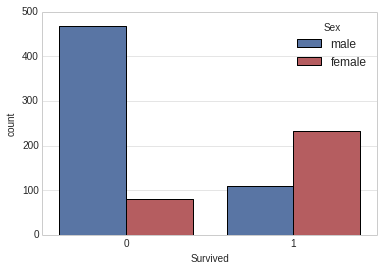

In [10]:
sns.countplot(x='Survived', hue='Sex', data=titanic, palette=palette)

Of those that died, how many died from the upper-class passengers of the ship?

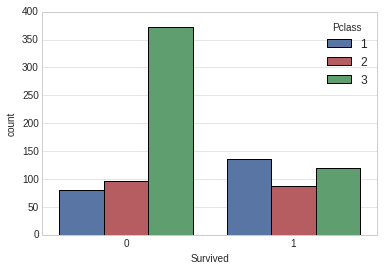

In [11]:
sns.countplot(x='Survived', hue='Pclass', data=titanic, palette=palette)

## Descriptive Statistics

Next, let's do some basic descriptive statistics to get a better understanding of the distribution of some of the data.

The following shows the distribution of the age of the passengers.

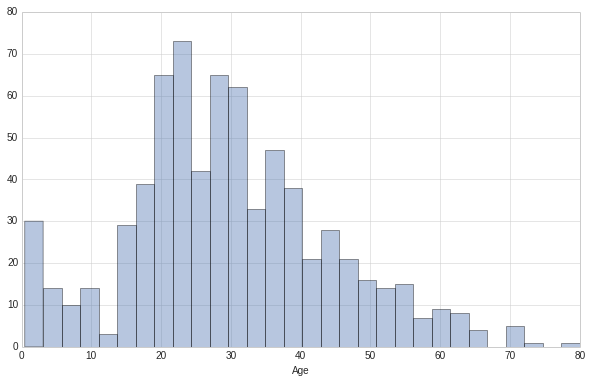

In [12]:
plt.figure(figsize=(10, 6))
sns.distplot(titanic['Age'].dropna(), kde=False, color=palette[0], bins=30)

What about the number of siblings or spouses? Most travelled alone!

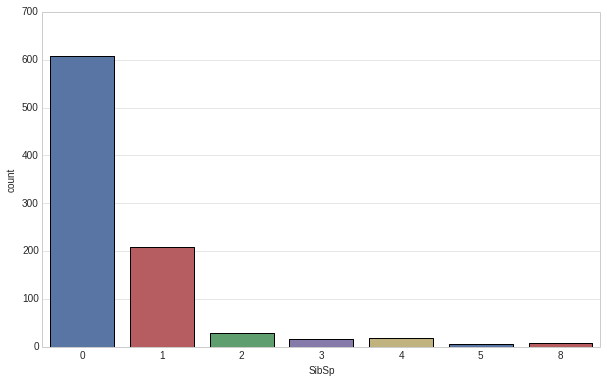

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='SibSp', data=titanic, palette=palette)

What is the distribution of the fare price of passengers?

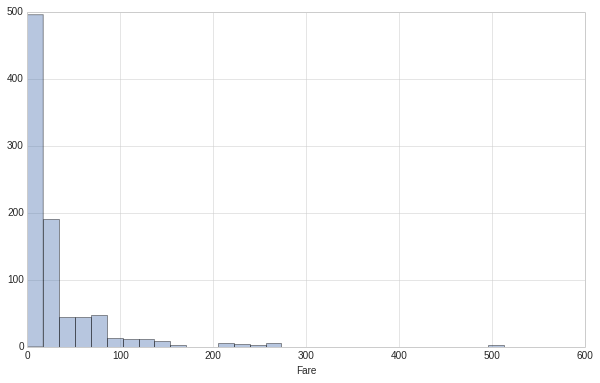

In [14]:
plt.figure(figsize=(10, 6))
sns.distplot(titanic['Fare'].dropna(), kde=False, color=palette[0], bins=30)

# Data Cleaning

Now that we have a better understanding of the data, let us go back and revising the missing data and clean it.

The easiest way to replace the missing data for the passenger's age is to have descriptive statistics for the mean/median age of each class of passengers. We can use boxplots to assist us with this.

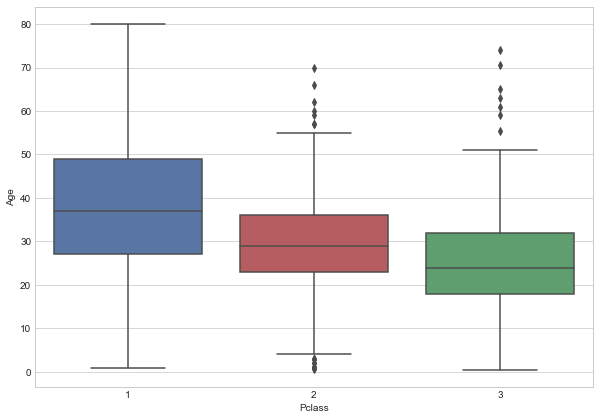

In [12]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Pclass', y='Age', data=titanic, palette=palette)

A more detailed breakdown can be achieved using pandas directly, here we will round to the mean age for each class.

In [16]:
titanic.groupby('Pclass')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.0,38.233441,14.802856,0.92,27.0,37.0,49.0,80.0
2,173.0,29.877630,14.001077,0.67,23.0,29.0,36.0,70.0
3,355.0,25.140620,12.495398,0.42,18.0,24.0,32.0,74.0


Next, we will impute this data (replacing the missing values) with an esimate of the age given the mean of the age for each class.

We will use the powerful apply function of pandas, making it easy to map an operation to every row of the dataset.

In [17]:
def impute_age(cols):
    """Imputes the missing age data using an appropriate value."""
    age_map = [38, 30, 25]
    age, pclass = cols[0], cols[1]
    if pd.isnull(age):
        return age_map[int(pclass-1)]
    else:
        return age

In [18]:
titanic['Age'] = titanic[['Age', 'Pclass']].apply(impute_age, axis=1)

Next, for the remaining cabin and embarked data columns it's easiest to just remove the entire Cabin column as there is so much data missing already.

For the Embarked column It's eaiest to just remove the few missing roles, slightly reducing the rows we have for our dataset.

In [19]:
titanic.drop('Cabin', axis=1, inplace=True)
titanic.dropna(inplace=True)

A final review to ensure that all of our missing data has been corrected.

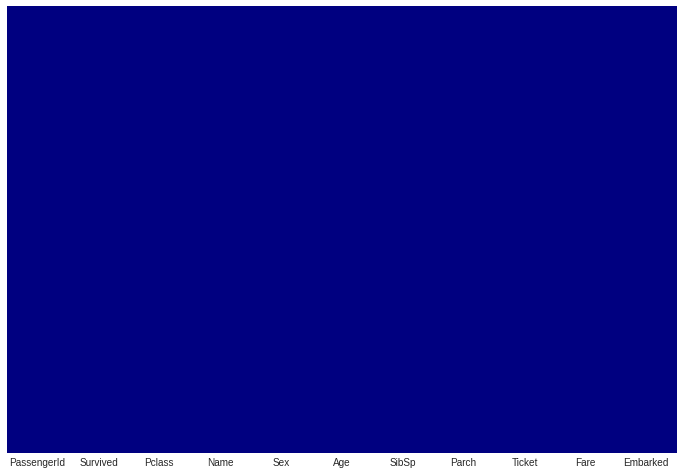

In [21]:
plt.figure(figsize=(12, 8))
sns.heatmap(titanic.isnull(), yticklabels=False, cbar=False, cmap='jet')

In [22]:
# Final check missing data
titanic[titanic.isnull().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked


# Feature Engineering

Now that the data has been cleaned the next step is feature engineering, we need to encode the data in a way that is optimal for the machine learning models, as well as trying to extract any other valuable information from the data.

First we need to conver the sex categorical column from text to a numeric represtation, where a 1/0 represents the value instead.

In [23]:
# Factorize provided by pandas does all the work for us!
sex = pd.get_dummies(titanic['Sex'], drop_first=True)
sex.head()

,male
0,1
1,0
2,0
3,0
4,1


Next, we need to use the get_dummies method to convert the categorical
into separate columns with a binary indicator.

In [24]:
embark = pd.get_dummies(titanic['Embarked'])
embark.head()

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


Following that, we also need to convert the number of simblings and
parents and children columsn

In [25]:
# Factorize the sibsp and parch as multiple columns
sibsp = pd.get_dummies(titanic['SibSp'], prefix='SibSp')
sibsp.head()

,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0


In [26]:
parch = pd.get_dummies(titanic['Parch'], prefix='Parch')
parch.head()

,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


### Adding the Feature Engineered Data

There is a lot more that we could do, such as extracting the name/title from the ticket (perhaps unmarried women were more likely to survive?). But for now let's add all the feature engineered data to our data and remove the remaining columns we can't use.

In [27]:
# Remove old features and then add all of the new features
titanic = titanic.drop(['PassengerId', 'Sex','Embarked', 'Name','Ticket',
                        'SibSp', 'Parch'], axis=1)
titanic = pd.concat([titanic, sex, embark, sibsp, parch], axis=1)
titanic.head()

,Survived,Pclass,Age,Fare,male,C,Q,S,SibSp_0,SibSp_1,...,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0,3,22.0,7.2500,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
1,1,1,38.0,71.2833,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,3,26.0,7.9250,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
3,1,1,35.0,53.1000,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
4,0,3,35.0,8.0500,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0


# Creating a Model

With our data cleaned, feature engineered, and ready to use the next step is to create a model, we'll be looking at a few different approaches and comparing the results to see what the highest accuracy we can achieve is.

## Data Holdout

We need to split our data into train and test sections, we want to have a portion for testing/evaluating our model that is completely removed and withheld from our model training.

In [28]:
# Define our training and prediction data
# By default drop returns a view/copy with the column removed
X = titanic.drop('Survived', axis=1)
y = titanic['Survived']

In [29]:
# This function provided by scikit-learn will automatically
# create a randomized train and test split, withhold all test data from
# model when training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=42)

## Initial Model

Generally it is *always ideal* to start out with a simple model for your problem and then increase the complexity after you already have baseline test results.

We are going to create a model using LogisticRegression, which generally produces OK results and is much faster than more complex approaches (e.g. Deep Learning).

In [30]:
logmodel = LogisticRegression()

# We fit (train) the model on our training data
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Generate our predictions for the withheld test data

In [31]:
predictions = logmodel.predict(X_test)

## Evaluation

Now that we have the predicted outcome (survived / died) for each passenger in the test dataset, let's evaluate the performance of our model.

In [32]:
print(classification_report(y_test, predictions))
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))

             precision    recall  f1-score   support

          0       0.84      0.87      0.86       167
          1       0.77      0.72      0.75       100

avg / total       0.81      0.82      0.82       267

Accuracy: 0.816479400749


Our accuracy is roughly ~82% that's not bad, we're only wrong 18% of the time!

# Next Model

Now that we have a baseline using a simple model, is it possible that we can perform even better using a more complex model such as Support Vector Machines (SVM)?

We have a baseline of roughly ~82% can we beat it?

First we need to standardize the data, this is a requirement often for models such as SVM and Deep Learning.

Based on our earlier EDA, the data is more-or-less normally distributed, there is some obvious skew for some of the features, but it's likely fine to use the StandardScaler, this centers and scales all of the data.

In [33]:
# Lets standard scale all our training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [34]:
# Now, let's create our SVM model and test it
svmmodel = SVC()
# We fit (train) the model on our training data
svmmodel.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Let's evaluate our model, does it out-perform Logistic Regression?

In [35]:
# Scale our test data using our scaler
X_test_scaled = scaler.transform(X_test)
predictions = svmmodel.predict(X_test_scaled)
print(classification_report(y_test, predictions))
print("Accuracy: {}".format(accuracy_score(y_test, predictions)))

             precision    recall  f1-score   support

          0       0.84      0.86      0.85       167
          1       0.76      0.72      0.74       100

avg / total       0.81      0.81      0.81       267

Accuracy: 0.808988764045


**It performs slightly worse** With the added complexity of SVM models come a plethora of parameters, this is why it's always best to start simple first. There are probably a lot of modifications that could be made to the parameters or the standardizer used on the data, or perhaps optimization of the parameters for SVM.

Optimizing all these other variables is known as hyperparameter optimization.

# Now Your Turn

Are you able to create a model that outperforms the initial simple Logistic Regression model? Try for yourself and see what you're able to achieve, is it possible to get above 95% accuracy?
